# To Do

* improve executive summary


* add additional tests (e.g., overdispersion)


* add feature with continuous variable


* add additional features to improve predictability


* cost function, maximizing likelihood, and general logistic regression discussion


* improve confusion matrix graphics 


* add auc metric

# Executive Summary

[nbviewer](http://nbviewer.jupyter.org/github/nuclth/Python_Statistics/blob/master/Logistic_Regression.ipynb)

This is a notebook that implements logistic regression on a dataset. The problem is to predict whether a student will smoke based off whether their parents do or do not smoke. This is a simplest working example of logistic regression where the response variable is binary and the independent variable is either binary (in the first pass) or has three levels. 

This notebook is based off the notes and problem example in chapter 6.2 of the PSU [Stat 504](https://onlinecourses.science.psu.edu/stat504/node/150) course.

# Concepts

* logistic regression
* confusion matrix
* ROC curve
* dummy variables
* z statistic

# Dataset Creation

<br>
First let's import the relevant modules:

<br>

In [24]:
# import third party libraries
import pandas as pd
import statsmodels.api as sm

# import sklearn functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# import custom functions
from src.logreg_functions import *

<br>

Now we can create our dataset. The idea is we want to predict whether a student smokes or not given the information about whether either of their parents smoke. This can be visualized in a 2x2 table as given below. The latin letters `a, b, c, d` correspond to the number of students in a given category. 

<br>

| Student Smokes | Student Does Not Smoke
---------|--------
A Parent Smokes | a | b
No Parent Smokes | c | d

Before we continue, let's take a guess:
<br><br>
<center>**Hypothesis**: Students with parents who smoke, are more likely to be smokers themselves.</center>

<br>
We'll see if this hypothesis is justified or not further in. First to create our data, we call a python function, `create_smoking_data (a, b, c, d)` to fill a dataframe with student statistics. Each response will be a Y/N string.

<br>

In [2]:
df = create_smoking_data(816, 3203, 188, 1168)

<br>
For the table above, these numbers would correspond to the following populations (again these numbers are taken from the PSU [Stats 504](https://onlinecourses.science.psu.edu/stat504/node/150) course),

| Student Smokes | Student Does Not Smoke
---------|--------
A Parent Smokes | 816 | 3203
No Parent Smokes | 188 | 1168

<br>
Let's do a quick check through the dataframe to make sure everything looks ok.

<br>

In [3]:
df.head()

,parent_smoking,student_smoking
0,Y,N
1,Y,N
2,N,N
3,Y,Y
4,N,N


In [4]:
df.tail()

,parent_smoking,student_smoking
5370,Y,N
5371,N,N
5372,Y,N
5373,Y,N
5374,Y,N


<br>
Looks good. How about on a more macroscopic scale?

<br>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5375 entries, 0 to 5374
Data columns (total 2 columns):
parent_smoking     5375 non-null object
student_smoking    5375 non-null object
dtypes: object(2)
memory usage: 84.1+ KB


<br>
So we see that we have 5375 total entries with no missing data (as expected given that's how we constructed it). 

<br>

In [6]:
df.describe()

,parent_smoking,student_smoking
count,5375,5375
unique,2,2
top,Y,N
freq,4019,4371


<br>
Our dataframe holds two unique values (Y/N) as expected for a binary variable and response. We can also see from the `top` and `freq` outputs that our dataset is weighted heavily towards parents who smoke and students who don't.

Let's reinforce these points with some graphics, first with absolute counts and then with the relative percentage of each population:

<br>

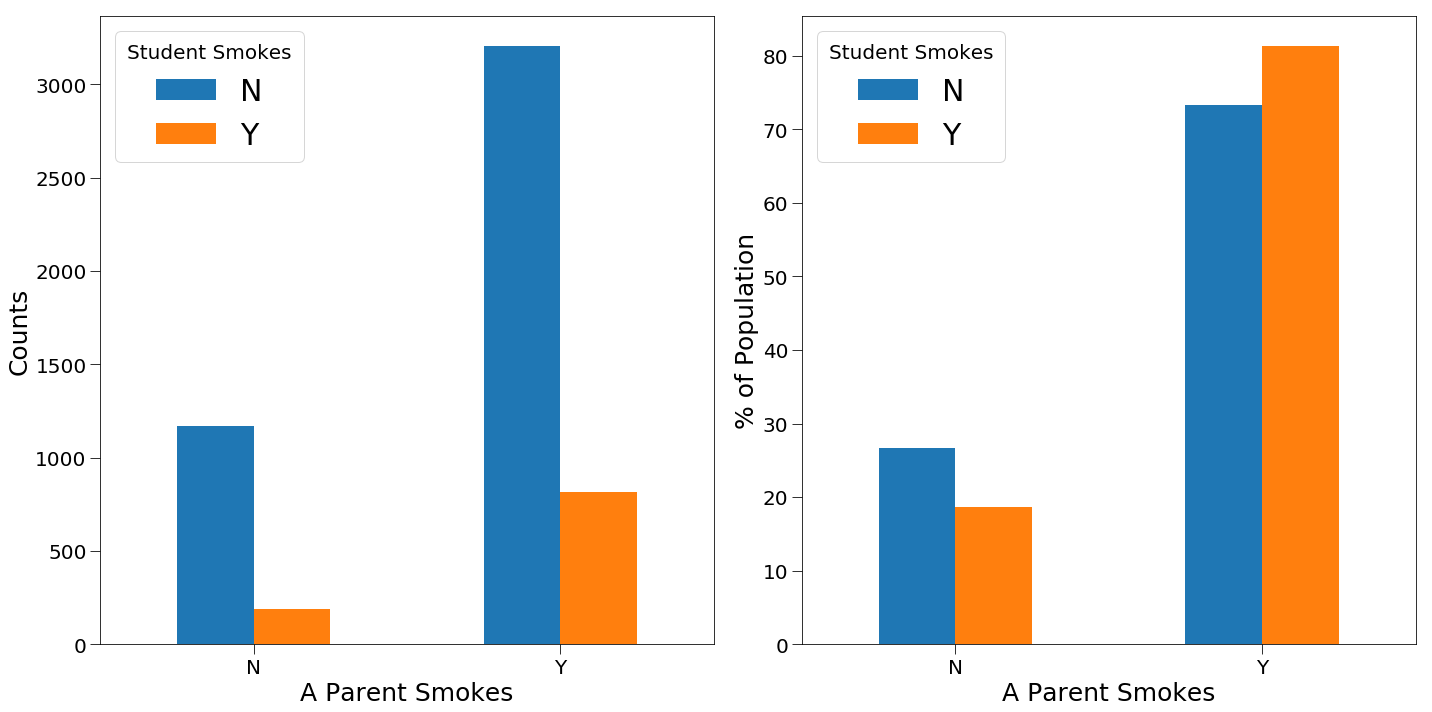

In [7]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

plot_cat (df, ax=ax[0], rel=False)
plot_cat (df, ax=ax[1], rel=True)
plt.tight_layout()
plt.show()

<br>
Again as seen from the absolute counts, our dataset overrepresents students who don't smoke and parents who do. On the relative side, the percentages of the two groups in a given bin should be approximately equal if there is no relationship between the variable and response. However, looking at the distribution above, there is a slight imbalance where students who smoke are more likely to have parents who smoke relative to students who don't. 

This demonstrates, assuming there was no bias in how the data was drawn and that our statistical sample is large enough, that there exists some correlation between parents smoking and students smoking.

<br>

# Logistic Regression

Logistic regression is a method used for binary classification (student smoking = Y/N). Here we perform it over one categorical variable $x$ which can take values of 0 or 1. The idea behind logistic regression is that we want to retain the advantage of linearity in a model but allow for our target variable to be constrained to be between 0 and 1 (rather than $-\infty$ to $\infty$ as in linear regression). This is accomplished in logistic regression using the logistic function. Thus the probability for student $i$ to smoke is $\pi_i$ and is given by,

$$\pi_i = \frac{\exp(\beta_0 + \beta_1 x_i)}{1 + \exp(\beta_0 + \beta_1 x_i)}$$

$$ \text{logit} \left( \pi_i \right) \equiv \text{log} \left( \frac{\pi_i}{1 - \pi_i} \right) = \beta_0 + \beta_1 x_i$$

<br>
Now we can create our training and validation datasets. First let's map the our Y/N to numerical values 1/0 and split our data into a **training set** and a **validation set** with **80%** in the former and **20%** in the latter:

<br>

In [8]:
# Y/N to 1/0 map
df['student_smoking'] = df['student_smoking'].map(lambda x: 1 if x == 'Y' else 0)
df['parent_smoking'] = df['parent_smoking'].map(lambda x: 1 if x == 'Y' else 0)

# number of training samples
num = 4300

# split into training/validation sets
train = df.copy()
valid = df.iloc[num:]
train = df.drop(train.index[num:])

<br>
Now pull off the true response for each student into two new series for the training/validation datasets, then drop the same variables for the fit and validation.

<br>

In [9]:
# create series for training/validation response
train_res = train['student_smoking'].copy()
valid_res = valid['student_smoking'].copy()

# drop response from training/validation set
train = train.drop(['student_smoking'], axis=1)
valid = valid.drop(['student_smoking'], axis=1)

# add a constant term for the intercept
train = sm.tools.tools.add_constant(train, prepend=False, has_constant='skip')
valid = sm.tools.tools.add_constant(valid, prepend=False, has_constant='skip')

# fit the model
logit = sm.Logit(train_res, train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.486196
         Iterations 6


<br>
Let's see how we did.

<br>

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        student_smoking   No. Observations:                 4300
Model:                          Logit   Df Residuals:                     4298
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                0.004868
Time:                        14:52:49   Log-Likelihood:                -2090.6
converged:                       True   LL-Null:                       -2100.9
                                        LLR p-value:                 6.107e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
parent_smoking     0.4214      0.096      4.399      0.000       0.234       0.609
const             -1.7634      0.085    -20.673      0.000      -1.931      -1.596
==================================================================================
"""

<br>
There's a lot to unpack here so let's focus on just a few crucial points:

* Our constant coefficient is approximately $\beta_0 \approx -1.8$. This means that the probability for a student to smoke without smoking parents is $\pi \approx 14\%$. 


* The parental smoking coefficient is approximately $\beta_1 \approx 0.45$. The means that with a smoking parent, a student's probability to smoke is $\pi \approx 20\%$, a risk increase of around 1.5 times. Note that since the coefficient is positive, the correlation is positive.


* Our z value for $\beta_0$ is large while the the value for $\beta_1$ is somewhat smaller but still large. Given the sizes, we can say that the coefficients are statistically meaningful. For more information on z values, see the appendix.

Looking at the course page for the [Stat 504](https://onlinecourses.science.psu.edu/stat504/node/150) course, we see that our values for the training set are quite close to the expected values: 

$$\beta_0 = -1.827 \ , \qquad \beta_1 = 0.459$$

<br>
So we seem to have a decent fit indicating some meaningful relationship between our variable and response. But how predictive is our model? Putting in our validation set, we see that we get our two possible probability outputs as outlined above,

<br>

In [11]:
predictions = result.predict(valid)
predictions.unique()

array([ 0.14636364,  0.2071875 ])

<br>
But what threshold do we set? That is, what probability cutoff do we use to decide which student goes in which bin? Note that here we only have one possible threshold (a value between 0.14 and 0.2) as any threshold would put alll students into one bin or the other. A way to assess a given threshold choice is to look at a confusion matrix. A confusion matrix is a table showing predicted responses on one table axis and true reponses on the other. If the model we are using is perfect, the confusion matrix should be diagonal.

<br>

In [12]:
# map prediction to 1/0 for a threshold = 0.17
pred_map = predictions.map(lambda x: 1 if x > 0.17 else 0)

confusion_matrix (valid_res, pred_map)

array([[229, 666],
       [ 27, 153]])

Documentation for the confusion matrix output is given [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). In short: 

* $C_{0,0}$ are true negatives
* $C_{1,0}$ are false negatives
* $C_{0,1}$ are false positives
* $C_{1,1}$ are true positives

With information from this table, we can also construct two important metrics to assess a binary classification model: the true positive rate (TPR) and false positive rate (FPR). Their formulas are given by:

$$ \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \enspace ,  \qquad \text{FPR} \equiv \frac{\text{FP}}{\text{FP + TN}} $$

where

* TP is the number of true positives
* FN is the number of false negatives
* FP is the number of false positives
* TN is the number of true negatives

The denominators in each correspond to the number of actual positives and actual negatives for the TPR and FPR respectively. For the table above, the TPR and FPR are given by:

$$\text{TPR} = \frac{153}{180} = 0.85 \enspace , \qquad \text{FPR} = \frac{666}{895} = 0.74 $$

Another way to access this same information is using a receiver operating characteristic (ROC) curve. This will come in handy as it will allows us to explore the same information for all thresholds simulatenously. 

In [13]:
fpr, tpr, thres = roc_curve (valid_res, predictions)

rocdf = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thres=thres))
rocdf

,fpr,thres,tpr
0,0.000000,1.207187,0.00
1,0.744134,0.207187,0.85
2,1.000000,0.146364,1.00


<br>
And we can see for our threshold choice (really threshold choice in the same range) we exactly reproduce the expected TPR and FPR values. 

Now let's plot the ROC curve,

<br>

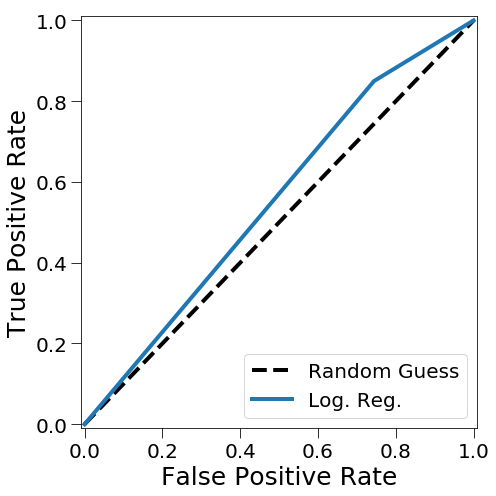

In [14]:
plot_roc (rocdf)

<br>
and we see that our model isn't particularly great. The dashed line above is a baseline that corresponds to just randomly guessing whether a student smokes or not and the blue line connects points of different TPR/FPR values for different threshold choices. As discussed previously, there is only one threshold value where we can actually make a prediction other than grouping everyone into one bin. With this choice, we get back a false positive rate of 73% and a true positive rate of 82%. This is better than random guessing though not by much. Clearly our model needs improving.

<br>

# Adding a New Variable

<br>
Our previous model is likely too simplistic. Let's try adding a new variable by splitting up the parent smoking variable into two groups, one where both parents of the student smoke and another where only one smokes:

<br>

| Student Smokes | Student Does Not Smoke
---------|--------
Both Parents Smoke | a | b
One Parent Smokes | c | d
No Parent Smokes | e | f

<br>
This requires a new logistic regression function where our probability $\pi_i$ for student $i$ now has two possible binary inputs $x_{1,i}$ and $x_{2,i}$,

$$\pi_i = \frac{\exp(\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i})}{1 + \exp(\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i})}$$

$$ \text{logit} \left( \pi_i \right) \equiv \text{log} \left( \frac{\pi_i}{1 - \pi_i} \right) = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}$$

<br>
Above, $x_1$ is 1 when *only one* parent smokes and zero otherwise. $x_2$ is 1 when *both* parents smoke and zero otherwise. Therefore with only two variables, we cover all three possibilities. 

We again call a previously defined python function, `create_smoking_data_mod (a, b, c, d, e, f)` to fill a dataframe with the values as specified in the [Stat 504](https://onlinecourses.science.psu.edu/stat504/node/150) course. 

<br>

In [15]:
df = create_smoking_data_mod (400, 1380, 416, 1823, 188, 1168)

<br>
This would fill the preceding table in the following way,

<br>

| Student Smokes | Student Does Not Smoke
---------|--------
Both Parents Smoke | 400 | 1380
One Parent Smokes | 416 | 1823
No Parent Smokes | 188 | 1168

<br>
And like before, let's make a quick plot to see what this data looks like in absolute and relative terms:

<br>

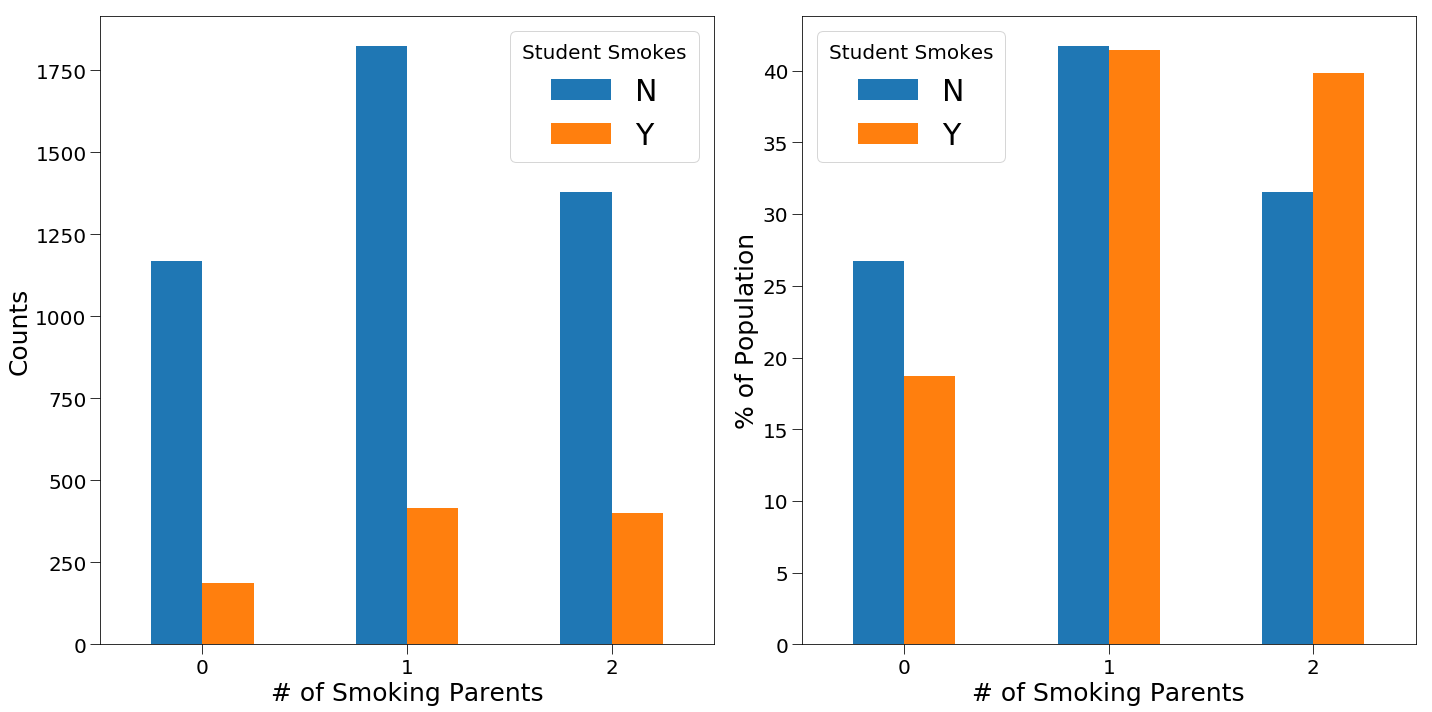

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

plot_cat_mod (df, ax=ax[0], rel=False)
plot_cat_mod (df, ax=ax[1], rel=True)
plt.tight_layout()
plt.show()

<br>
Note that since our categorical variable now has three possible values, we need to create some dummy variables to represent the different possibilities: 

<br>

In [17]:
# map response Y/N to 1/0
df['student_smoking'] = df['student_smoking'].map(lambda x: 1 if x == 'Y' else 0)

# create/add dummy variables and drop superfluous terms
dum_var = pd.get_dummies(df['parent_smoking'], prefix='#_smoke_par')
df = pd.concat([df, dum_var], axis=1)
df = df.drop(['parent_smoking', '#_smoke_par_0'], axis=1)

<br>
As before we map student Y/N responses to 1/0. We also drop the original parent smoking variable as it is replaced by our dummy variables. We also drop one of the dummy variable columns as it is superfluous, i.e., [0,0], [0,1], and [1,0] exhaust our 3 possibilities for the remaining two dummy variables. After these operations, our data now looks like this:

<br>

In [18]:
df.head()

,student_smoking,#_smoke_par_1,#_smoke_par_2
0,0,0,1
1,0,1,0
2,0,0,0
3,0,1,0
4,0,0,0


<br>
Finally, let's do exactly what we did before in splitting off our data into a training/validation dataset in an 80/20 ratio.

<br>

In [19]:
# number of training samples
num = 4300

# split into training/validation sets
train = df.copy()
valid = df.iloc[num:]
train = df.drop(train.index[num:])

# create response series
train_res = train['student_smoking'].copy()
valid_res = valid['student_smoking'].copy()

# drop response from training/validation set
train = train.drop(['student_smoking'], axis=1)
valid = valid.drop(['student_smoking'], axis=1)

# add an intercept term
train = sm.tools.tools.add_constant(train, prepend=False, has_constant='skip')
valid = sm.tools.tools.add_constant(valid, prepend=False, has_constant='skip')

# fit the model
logit = sm.Logit(train_res, train)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.485034
         Iterations 6


In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        student_smoking   No. Observations:                 4300
Model:                          Logit   Df Residuals:                     4297
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                0.005883
Time:                        14:52:55   Log-Likelihood:                -2085.6
converged:                       True   LL-Null:                       -2098.0
                                        LLR p-value:                 4.358e-06
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
#_smoke_par_1     0.3212      0.105      3.062      0.002       0.116       0.527
#_smoke_par_2     0.5230      0.107      4.886      0.000       0.313       0.733
const            -1.7618      0.086    -20.458      0.000      -1.931      -1.593
=================================================================================
"""

<br>
As before we touch on a few points

* Our coefficients found are: $\beta_0 \approx -1.8$, $\enspace \beta_1 \approx 0.37$, $\enspace \beta_2 \approx 0.55$.


* The baseline probability for a student to smoke without smoking parents is still $\pi \approx 14\%$. 


* There is a positive correlation with having one parent smoke and a student smoking. One parent smoking raises the probability to $\pi \approx 19\%$.


* There is a positive correlation with having both parents smoke and a student smoking. Both parents smoking raises the probability to $\pi \approx 22\%$.


* Our z values are again large enough to say that our variables are statistically significant.

<br>

The expected values from the Stat 504 course are:

$$\beta_0 = -1.826 \enspace , \qquad \beta_1 = 0.351 \enspace , \qquad \beta_2 = 0.588 $$

<br>
and we can see that our coefficients are quite close to the expected values. But again, how does our model do in predicting our validation set?

<br>

In [21]:
preds = result.predict(valid)

print (preds.unique())

[ 0.19145394  0.22464789  0.14656772]


In [22]:
fpr, tpr, thres = roc_curve (valid_res, preds)

rocdf = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thres=thres))
rocdf

,fpr,thres,tpr
0,0.000000,1.224648,0.000000
1,0.312430,0.224648,0.445055
2,0.722284,0.191454,0.835165
3,1.000000,0.146568,1.000000


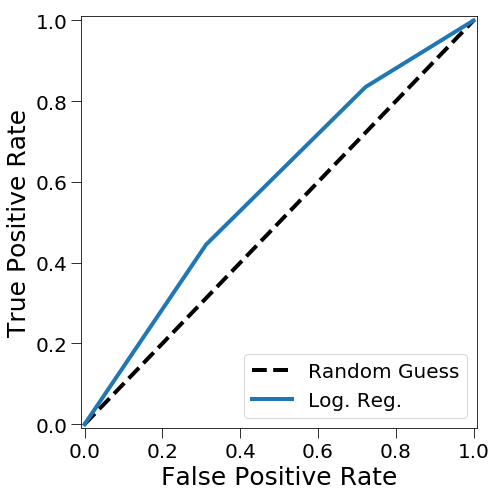

In [23]:
plot_roc (rocdf)

<br>
Again our model is not working that well although it is better than before. Likely it is still too simplistic as our model only allows for two possible threshold choices. That is, we can choose to place every student with a smoking parent into the smoking bin, or alternatively only place those with two smoking parents in the smoking bin. 

This classification scheme is likely too simplistic to account for the complexities of human behavior and would require additional features to increase predictive power. Some features that could potentially be included are:

* Household income
* Student grades
* Parental employment and/or education
* Student disciplinary history
* Student age
* Student friends' smoking status
* Other parental identifiers 

<br>

# Business Decisions

So assuming we can't improve our model with new features, how would we go about using it? We have two possible thresholds to consider but which one to use is situational:

1. Supposing we want to discourage student smoking in a low cost and minimal way, say by distributing an informational pamplet to all students the model classifies as smoking. In that case, we might opt for the higher TPR values (81%). As the method is low cost and not invasive, we might not care that we also give pamphlets to students who aren't currently smoking (FPR = 73%).
<br><br>
2. In contrast, suppose we wanted to discourage student smoking using a higher time/cost method such as scheduled counseling sessions. Just to start, this would probably be inadvisable with our current model due to the small predictive power. But supposing we went ahead anyway, we would probably opt for a method with a lower FPR (31%) since we would be concerned about wasting resources. 

# Appendix

## Z Values

For more on z values see the PSU [Stat 414](https://onlinecourses.science.psu.edu/stat414/node/269) course.

$$Z = \left(\bar{X} - \mu\right) \frac{\sqrt{N}}{\sigma}$$

* $\bar{X}$ is the found mean
* $\mu$ is the expected mean
* $\sigma$ is the standard deviation
* $N$ is the total number of samples

This is to say that $Z$ is the difference between the found mean ($\bar{X}$) and the expected mean ($\mu$) weighted by the standard error $\sigma / \sqrt{N}$. So when testing a variable for significance, the found mean will be the coefficient value and $\mu$ will be 0 (mean of a normal distribution). So the larger the coefficient is divided it's standard error, the larger it's z value.

## Resources

* PSU [Stat 414](https://onlinecourses.science.psu.edu/stat414/node/269) course on z statistics
* PSU [Stat 504](https://onlinecourses.science.psu.edu/stat504/node/150) course on logistic regression